# Longitudinal Dynamic Vehicle Model








This notebook is an implementation of a general longitudinal dynamics model for an automobile vehicle. The primary relations for forces acting on the vehicle moving forward on an incline angle are shown below 

![longitudinal](longitudinal-car-v0.06.png)

The dynamics model for this project express the overall force equation shown above with more
specific equations and parameters that can be set to model a particular vehicle design. The main longitudinal components from head to tail basically are: engine, torque converter, tranmission, and finally the wheels where the frictional forces from the tires on the road surface move the vehicle. 

The main input to the system is the throttle level and the output will be a one-dimensional linear position. Vehicle specific values that can be set are: overall engine inertia value, vehicle mass, gear ratio, effective radius, tire force, acceleration due to gravity, aerodynamic and frictional cooeficients, and a tire force coeeficient on the slip ratio. The runtime parameters that can be set are: sample increment for discrete time, and total seconds to run the simulation.

The model consists of the main vehicle equations for torque (rotational force) and force (longitudinal force). 

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}


$J_e$ is the engine moment of inertia value, $\dot{\omega}_e$ is the engine angular acceleration , $T_e$ is the engine torque, $GR$ is the combined gear ratio, $r_{eff}$ is the effective tire radius, $F_{load}$ is the total load force, $m$ is the vehicle mass, $x$ is the vehicle position, and $F_x$ is the tire force. The forces are condensed into $F_x$ = $F_{xf}$ + $F_{xr}$ and $F_{load}$ = $F_{aero}$ - $R_{xf}$ - $R_{xr}$ - $mg\sin{\alpha}$

The engine torque is calculated from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

The load forces consist of aerodynamic drag $F_{aero}$, rolling friction $R_x$, and gravitational force $F_g$ produced from the incline angle $\alpha$. The aerodynamic drag is a quadratic model and the friction is a linear one.

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}


Since the model is basically designed for forward motion only, where ($\dot{x} \ge 0$}, the absolute value in the friction equation is not essential, but may have an impact if the vehicle would not have enough forward force to overcome an incline that is too steep and slip backwards.
 


The tire force is calculated from the engine rotational rate and wheel slip equations

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

where $\omega_w$ is the wheel angular velocity and $s$ is the slip ratio. 



The overall longitudinal force relation for the vehicle and its motion is

\begin{align}
    m\ddot{x} &= F_x - F_{load}\\
\end{align}


and then expressed in terms of acceleration to begin the time step
integrations to obtain velocity and linear position 

\begin{align}
    \ddot{x} &= \frac{F_x - F_{load}}{m}\\ 
\end{align}




## Implementation

The primary input to the system is a throttle signal. This is used to directly calculate engine torque that is then transformed through the powertrain and vehicle model equations to accelerate the vehicle into forward motion. 

The model runs by incrementing through discrete time for a specified period while calculating the longitudinal dynamic equations and updating the state space components of acceleration, velocity and position.

In this implementation, throttle signal is in the range $x_\theta \in [0,1]$. The vehicle has an initial velocity of 5 m/s and engine speed of 100 rad/s and also when the reset() function is used. A discrete sampling time of 10ms is used for numerical integration. All other model parameters are defined in the Vehicle class.



In [1]:
#mk v0.14

#import sys
import numpy as np
import matplotlib.pyplot as plt


class Vehicle():
    def __init__(self):

        # ==================================
        #  longitudinal vehicle model 
        #  system equation parameters & variables
        # ==================================
        
        # set parameters
        
        # Te engine torque from throttle percentage in range [0,1]
        # coefficients for engine torque quadratic Te <- (throttle input * quadratic)
        self.a_0 = 400 
        self.a_1 = 0.1
        self.a_2 = -0.0002

        # gear ratio, effective radius, mass, inertia
        self.GR = 0.35  # gear ratio
        self.r_e = 0.3  # effective radius [meters]
        self.J_e = 10   # overall engine inertia for vehicle model 
        self.m = 2000   # mass of vehicle [kg]
        self.g = 9.81   # acceleration due to gravity on earth [m/s^2]

        # aerodynamic & friction coefficients
        self.c_a = 1.36     # aerodynamic 
        self.c_r1 = 0.01    # frictional 

        # tire force
        self.c = 10000  # coef on slip ratio when abs(c*s) < 1
        self.F_max = 10000 # otherwise is Fmax

        # vehicle system state variables
        self.x = 0  # x linear position
        self.v = 5  # x-dot velocity (of vehicle)
        self.a = 0  # x-double-dot acceleration of vehicle
        self.w_e = 100  # engine angular velocity (or speed) omega-sub-e
        self.w_e_dot = 0   # engine angular acceleration omega-sub-e-dot

        # time increment for discrete time space
        self.sample_time = 0.01

    def reset(self):
        # reset state variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100 # [r/s] ~955 RPM idle probably something
        self.w_e_dot = 0

The engine dynamic and force equations are implemented in the cell below. The function $\textit{time_step}$ takes the inputs throttle $x_\theta$ and incline angle $\alpha$ and performs numerical integrations over a single timestep to update the state variables. 

In [2]:
class Vehicle(Vehicle):
    def time_step(self, throttle, alpha):
        
        # euler forward time step integration
        
        assert(self.g == 9.81) # make sure on planet earth
        
        #  vehicle model equations
        
        ### engine torque from throttle & engine angular velocity
        Te = throttle*(self.a_0 + self.a_1*self.w_e + self.a_2*(self.w_e*self.w_e))
                
        ### calculate tire force Fx ###
        
        # wheel angular velocity
        w_w = self.GR * self.w_e
        
        # slip ratio
        s = (w_w * self.r_e - self.v)/self.v 
        
        ## tire force ##
        if ( np.abs(s) < 1):
            Fx=self.c * s
        else:
            Fx = self.F_max
            
        ### calculate total load force  F_load ###
    
        # gravitational force due to road inclination
        Fg = self.m* self.g * np.sin(alpha)
        
        # rolling friction (rolling road resistance)
        Rx = self.c_r1 * self.v #approximation from front only
        
        # aerodynamic forces (drag)
        F_aero = self.c_a * (self.v*self.v) #x-dot squared
        
        ## total load force ##
        F_load = F_aero + Rx + Fg
        
        # now have:
        # engine torque (from throttle) Te, Load force F_load, Tire force Fx
        # so can get acceleration and time step integrate the state variables
        
        #vehicle acceleration       
        self.a = (Fx - F_load)/self.m 
        
        # step integration using time_step as delta-t
        # set the current position, velocity, and engine speed

        self.v = self.v + self.a*self.sample_time # 
        self.x = self.x + self.v*self.sample_time # 
            
        #engine angular (rotational) acceleration 
        self.w_e_dot = (Te - (self.GR * self.r_e * F_load)) / self.J_e 
        
        # engine rotational velocity          
        self.w_e = self.w_e + self.w_e_dot*self.sample_time 
        


## Testing the model over a flat surface

First test the equations by moving the vehicle over a flat surface with a constant throttle.
If the model is working properly, the velocity will gradually reach a limiting
value as the vehicle gains over opposing forces, aerodynamic drag, and tire force limit and attains a steady state. At the same time, the acceleraion will decline and level out as the rate of change of velocity decreases.

Experiment by changing the inclination angle while keeping the throttle constant to see how the model responds.

Also try negative angles (for a downward slope). In this case, downward directed forces due to gravity also accelerate the vehicle to a terminal velocity where it is eventually balanced by opposing forces.

Observe the relative changes of velocity, acceleration and position displayed in the plots to get an idea
of how the dynamics of system respond and change over time.





Using: throttle = 0.3      Angle =  0 (degrees)


Position over time


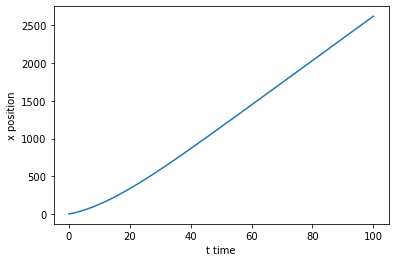


Velocity over position


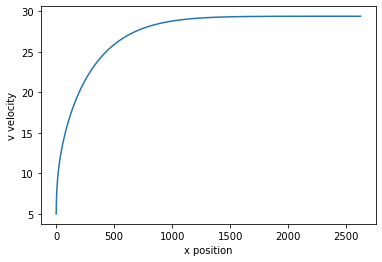


Velocity over time


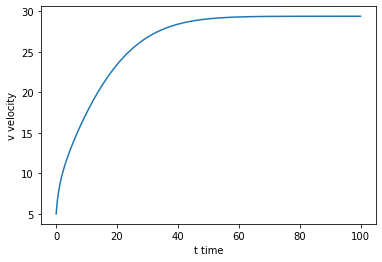


Relative velocity and acceleration


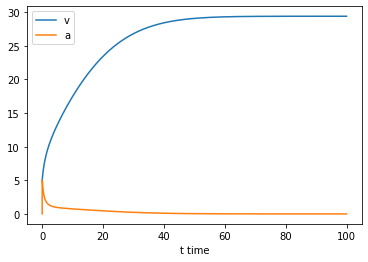

In [10]:
# FIRST linear flat surface test (alpha = 0)
# with constant throttle


sample_time = 0.01 # 10 ms
# can test with different total time to run
time_end = 100

model = Vehicle()
model.reset()

t_data = np.arange(0,time_end,sample_time)
v_data = np.zeros_like(t_data)

# position
x_data = np.zeros_like(t_data)
# acceleration
a_data = np.zeros_like(t_data)


# CAN CHANGE THIS #################

# throttle value in [0,1]

throttle = 0.3 #2#.2

###################################

# try some incline angles (in radians)
alpha = np.arctan(0.5/1)#np.pi/# np.pi/8 #flat surface
alpha_1 = np.arctan(3/60)
alpha_2 = np.arctan(9/90)
alpha_3 = 0

# select an incline angle to test
#alpha=alpha_1

## CAN CHANGE INCLINE ANGLE HERE #

alpha=0 # flat surface all the way if =0
#alpha=np.pi/8

##################################

for i in range(t_data.shape[0]):
    v_data[i] = model.v
    x_data[i] = model.x
    a_data[i] = model.a
    model.time_step(throttle, alpha)
#
print();print();print("Using: throttle =",throttle,"     Angle = ",int(np.rad2deg(alpha)),"(degrees)");print()

# position over time
print();print("Position over time")
plt.plot(t_data, x_data)
plt.xlabel("t time")
plt.ylabel("x position")
plt.show()



# velocity over position
print();print("Velocity over position")
plt.plot(x_data, v_data)
plt.xlabel("x position")
plt.ylabel("v velocity")
plt.show()

# velocity over time
print();print("Velocity over time")
plt.plot(t_data, v_data)
plt.xlabel("t time")
plt.ylabel("v velocity")
plt.show()

# velocity acceleration
print();print("Relative velocity and acceleration")
plt.plot(t_data, v_data, label='v')
plt.plot(t_data, a_data, label='a')
plt.xlabel("t time")
plt.legend()
#plt.ylabel("a acceleration")
plt.show()


## Model dynamics with terrain and velocity profiles

A simple two dimensional terrain model is used that has linear horizontal distance and height changes represented in Figure 1 and geometric throttle input profile is calculated from the diagram specifications in Figure 2.



![ramp](terraindiagram_v3.png)
<center>Figure 1 - Terrain</center>



![throttle](throttle-v0.05.png)

<center>Figure 2 - Velocity</center>






### Implementation

Using the Figure 2 profile, the throttle is applied for a total runtime of 20 seconds The vehicle begins at 20% throttle and gradually increases to 50% throttle. This is maintained for 10 seconds. Then the throttle decreases until it reaches 0 at 20 seconds. 

The implementation  time steps through the terrain geometry and the throttle profile while calculating the vehicle dynamics. A 10ms time increment is specified. The time, position, velocity, acceleration and incline angle are saved for analysis.




In [4]:

sample_time = 0.01 # 10 ms
time_end = 20  #total run time in seconds  480#120#20 #  120# 

t_data = np.arange(0,time_end,sample_time) # discrete time
x_data = np.zeros_like(t_data) # position
v_data = np.zeros_like(t_data) # velocity
a_data = np.zeros_like(t_data) # acceleration
y_data = np.zeros_like(t_data) # height (y )
angle_data = np.zeros_like(t_data) # save alpha also for analysis

# keep throttle data for analysis
throttle_data = np.zeros_like(t_data) 

# initialization

#throttle is expressed as a percent in [0,1]

# throttle starting position is 0.2
throttle = 0.2
# alpha the incline angle (in radians)
alpha = 0

# following the diagram

incline_angle_1 = np.arctan(4/50)
incline_angle_2 = 0
incline_angle_3 = np.arctan(8/60)
incline_angle_4 = 0


#incline_angle_1 = np.arctan(3/60)
#incline_angle_2 = np.arctan(9/90)
#incline_angle_3 = 0
#incline_angle_4 = 0

# make it easy
seconds = int(t_data.shape[0]/time_end)

# assume throttle changes are linear
# dx/dt is slope
throttle_rate_1 = (0.50-0.20)/(5*seconds) #slope 1 starts at 20%
throttle_rate_2 = 0 # keep throttle at position
throttle_rate_3 = -(0.50/(5*seconds))#slope 3

# create car model instance
model = Vehicle()
model.reset() # just to make sure
#model.v = 0 # don't use reset defaults?

for i in range(t_data.shape[0]): # i index into time increments 

    x_data[i] = model.x 
    v_data[i] = model.v
    a_data[i] = model.a
    
    # terrain
    # set incline angle depending on x position
    # ie how far along the path the auto is at
    
    if (model.x >=0 and model.x <= 50):
        alpha = incline_angle_1
       
    if (model.x > 50 and model.x <= 90):
        alpha = incline_angle_2
            
    if (model.x > 90 and model.x <= 150):
        alpha = incline_angle_3
       
    if (model.x > 150):
        alpha = incline_angle_4

    
    # throttle profile
    # set throttle depending on time traveled
        
    if (i <= 5*seconds):
        throttle = 0.20 + throttle_rate_1*i
        
    if (i > 5*seconds and i <= 15*seconds):       
        throttle = 0.50 + throttle_rate_2*i   
     
    if (i > 15*seconds): #
        throttle = 2 + (throttle_rate_3*i)
        if (throttle <=0):
            throttle =0 # dont reverse throttle
        
    model.time_step(throttle, alpha)        
        
    throttle_data[i]=throttle
    angle_data[i]=alpha




### Various plots runtime data for analysis

First, check the inputs over time to see if they correspond to the specified profiles

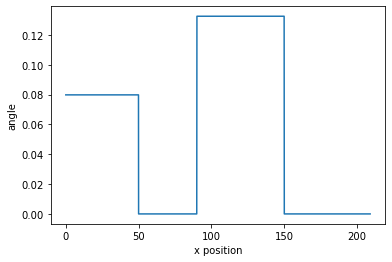

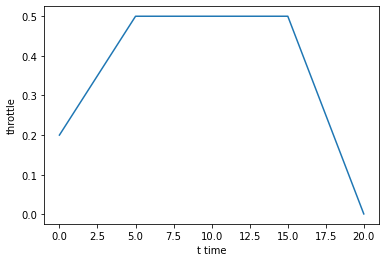

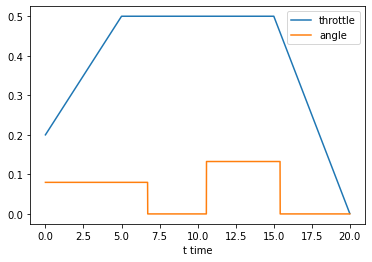

In [5]:


# angle over position
plt.plot(x_data, angle_data)
plt.xlabel("x position")
plt.ylabel("angle")
plt.show()
print()

 # throttle over time
plt.plot(t_data, throttle_data)
plt.xlabel("t time")
plt.ylabel("throttle")
plt.show()  
print()


#print();print("Check the inputs...");print()

# throttle angle
plt.plot(t_data, throttle_data, label='throttle')
plt.plot(t_data, angle_data, label='angle')
plt.xlabel("t time")
plt.legend()
#plt.ylabel("a acceleration")
plt.show()


### Check positon over time

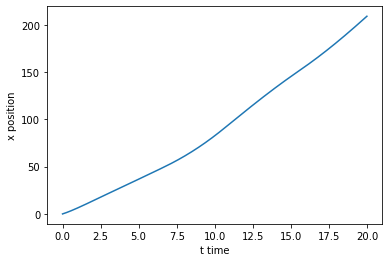

In [6]:

# horizontal position over time
plt.plot(t_data, x_data)
plt.xlabel("t time")
plt.ylabel("x position")
plt.show()


### Check velocity over time and position

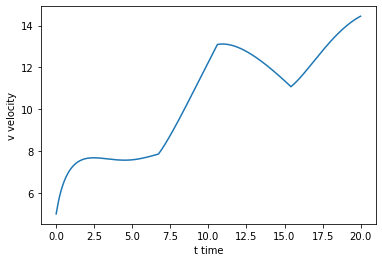

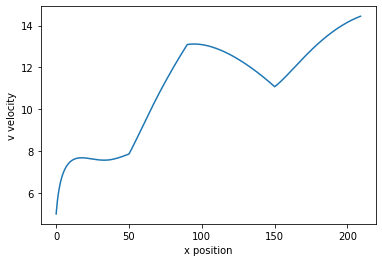

In [7]:

# velocity over time
plt.plot(t_data, v_data)
plt.xlabel("t time")
plt.ylabel("v velocity")
plt.show()

# velocity over position
plt.plot(x_data, v_data)
plt.xlabel("x position")
plt.ylabel("v velocity")
plt.show()

### Compare relative changes in velocity and acceleration

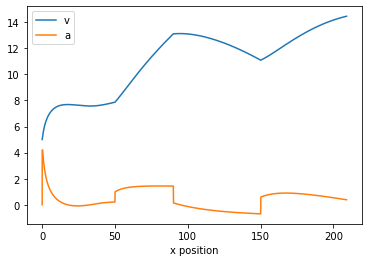

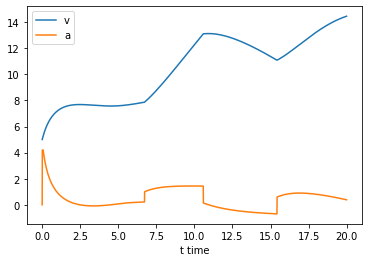

In [8]:

# velocity acceleration
plt.plot(x_data, v_data, label='v')
plt.plot(x_data, a_data, label='a')
plt.xlabel("x position")
plt.legend()
#plt.ylabel("a acceleration")
plt.show()



# velocity acceleration
plt.plot(t_data, v_data, label='v')
plt.plot(t_data, a_data, label='a')
plt.xlabel("t time")
plt.legend()
#plt.ylabel("a acceleration")
plt.show()



The velocity and acceleration comparison shows a jump in acceleration at the begining of each level surface
and some noticeable decreasing velocity when driving up the steeper slope

Where there is a flat surface the velocity may increase.
After 150 meters, there would eventually be enough aerodynamic resistance or other forces to eventually slow the vehicle down (if the throttle remains at zero and the model runs for enough time)
and the velocity would level off.


## Further model observations and analysis


Experiment by going back and changing the total runtime to 120s, 240s, 480s or more
Without any opposing forces generaged from an incline or aerodynamic conditions
it can take some time (and distance!) before the velocity finally starts to level off

